# Description
- This notebook consist from 3 part:
  1. Data download and preparation 
  2. Heat-wave hazard estimation by the PESETA IV methodology
     - A more comprehensive approach
     - goes to the detail of raster pixel
     - yearly and monthly heat-wave occurrence comparison
  3. Heat-wave hazard estimation by the XCLIM package
     - Fast for computing
     - tens of climate indices
     - goes to the detail of the clipped area
     - yearly heat-wave occurrence comparison


# Heat-Wave Hazard

#### 1. Heat-wave based on the PESETA IV methodology
For The heat-wave, we use the EURO-CORDEX (or Chelsa, or you can use your climate scenario) daily maximum temperature data. We used the methodology from the PESETA IV project https://joint-research-centre.ec.europa.eu/peseta-projects/jrc-peseta-iv_en

Specifically, a heat-wave is defined as a period ≥ 3 consecutive days with a maximum temperature above a daily threshold calculated for a 30-year-long reference period (for testing we choose a shorter period). At least a 30-year time series of daily values is needed to obtain a robust estimation of the indicator. The threshold is defined as the 90th percentile of daily maxima temperature, centered on a 31-day window.

For the Calculation of the Heat-wave, you can follow these next steps:

- Firstly look at the CLIMAAX hazard portal, if your area should suffer by Heat-Wave more frequently in the future (all these maps will be added)
- Secondly, look at the climate-adapt webpages:
    1. Heat days occurrence in the past [https://climate-adapt.eea.europa.eu/en/metadata/indicators/high-utci-days]
    2. Heat days occurrence in the future [https://climate-adapt.eea.europa.eu/en/metadata/indicators/apparent-temperature-heatwave-days]
    3. Tropical nights [https://climate-adapt.eea.europa.eu/en/observatory/++aq++metadata/indicators/tropical-nights/]
  
If you want to produce Heat-wave graphs with your data you can use this toolbox:
1. Import the packages
2. Create a directory structure
3. Set the CRS for the Euro-Cordex data
4. Download the data from the:

- CDS [https://cds.climate.copernicus.eu/cdsapp#!/dataset/projections-cordex-domains-single-levels?tab=form] (suggested, and used by this toolbox)
- Or Chelsa [ https://envicloud.wsl.ch/#/?prefix=chelsa%2Fchelsa_V2%2FGLOBAL%2F ### https://chelsa-climate.org/] (not bias-corrected, online version does not include the daily values)
- Or use your data.
5. Load a data convert Kelvin to Celsius
6. Calculate the Heat-wave occurrence for past and future
7. Plot the results and compare
8. Conclusion

#### Pros [+]
- The treshold for the heat-waves is calculated from the 3O year's monthly values - we can see the seasonal changes [XCLIM only for years]
- Calculates the heat-wave only based on 24h maximum 2m air temperature - less data to download [-15 GB then XCLIM]
- Calculates the heat-wave for years and months - [XCLIM only for years]
- Calculates the selected percentile and heat days duration (you can change the percentile) for each pixel - more precise estimation [XCLIM the same percentile for the whole selected area]
#### Cons [-]
- Long time for computation - for years and months it takes several hours [XCLIM is only a matter of minutes]
- Do not count with minimum air temperature - especially in the mountainous regions the heat can cool down at night [XCLIM also considers a minimum temperature]

#### 2. Heatwave based on the XCLIM package for the calculation of the climate indices [https://xclim.readthedocs.io/en/stable/indices.html]

- Heat and cold spells
- Heatwave frequency (years), max and total length

Different methodologies for the Heatwave identification. Need to download also the minimum temperature data. The heat-wave is estimated by the selected temperature thresholds for minimum and maximum temperature (these thresholds can be estimated based on the user preferences)

#### Pros [+]
- Heat-wave calculation based on the minimum and maximum temperature ### the estimation of the Heat is more truthful for some regions [PESETA IV only maximum temperature]- Shorter calculation time ### calculate only for the years and the treshold for temperature is the same for the whole selected region [1 hour less time for the computation, depending on the area of the pilot]h- s
Calculates the selected percent and heat day duration
- With only one line of code, is easier to understand ### [Peseta IV 2 pages of code]

#### Cons [-]
- Calculates the heat-wave based on 24h maximum and minimum 2m air temperature ### more data to download [+ 15GB than PESETA IV]
- Calculates the heat-wave only for years ### [PESETA IV calculates also for months]
- We do not see the code behind it - we need to trust to creators ### [PESETA IV provides the whole script] night

# 1. Data download and preparation

## Import packages

In [3]:
import zipfile        # working with the zip folders #
import os             # handling the current working directory
import rasterio       # netcdf and raster processing  #
from pathlib import Path # file system paths
import rioxarray as rxr # netcdf and raster processing
import rioxarray
import cdsapi         # API downloading
import numpy as np    # 2-3D array data handling
import pandas as pd   # data handling #
import xarray as xr   # 2-3D array data handling 
#from osgeo import gdal # Geo data handling 
import cartopy.crs as ccrs # netcdf data projection 
import cartopy.feature as cf # netcdf data projection 
import cartopy.crs as ccrs # netcdf data projection 
import matplotlib as mpl  #  data plot #
import matplotlib.pyplot as plt #  data plot #
from rasterio.crs import CRS  #  raster dat handling 
from pylab import pcolormesh,show,colorbar,plot,title,legend,subplot,savefig
from xrspatial.classify import reclassify
from matplotlib import pyplot
from rasterio.plot import show
from glob import glob
import geopandas as gpd
import rasterio as rio
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression
from ipyleaflet import Map, DrawControl, Marker, LayersControl
import ipywidgets as widgets
import leafmap.leafmap as leafmap
from localtileserver import get_leaflet_tile_layer, TileClient

## Create a directory structure

In [4]:
# Define the directory for the flashflood workflow preprocess
workflow_folder = 'Heat_workflow_test'

# Define directories for data and results within the previously defined workflow directory
data_dir = os.path.join(workflow_folder,'data')
results_dir = os.path.join(workflow_folder,'results')

# Check if the workflow directory exists, if not, create it along with subdirectories for data and results
if not os.path.exists(workflow_folder):
    os.makedirs(workflow_folder)
    os.makedirs(os.path.join(data_dir))
    os.makedirs(os.path.join(results_dir))

## Set a Cooridinate system

In [5]:
## CRS for Eurocordex data
rotated_pole = ccrs.RotatedPole(pole_latitude=39.25, pole_longitude=-162)
#dmin.rio.write_crs(rotated_pole, inplace=True)

## Download a data from the CDS

You can download a data from the CDS with the API - look at [https://cds.climate.copernicus.eu/api-how-to]

- Firstly you download a data for the past
- Secondly data for the future you can select the Climate scenario rcp 4.5 and 8.5

Based on the PesetaIV methodology you need to download at least 30 year period, to see a change in the Heat wave occurence. The most frequently 30 year periods used by the CDS are:

- for the past: 1971-2000 
- for the future: 2011-2040, 2041-2070 and 2070-2100

!!!! If you decide to use your own data for the computing of the heat wave, the data needs to address given criteria:
- the data should be in the raster format (.tif or .netcdf)
- you need to save them to the working directory (data_dir)
- and you need to change the name of the data in step 5. and also the name of the variable

### 1971-2000 maximum 2m temperature in the last 24h

In [ ]:
## Data for the 1971-2000
# Change KEY!!!
URL = "...................."   ##### PUT YOURs URL
KEY = "...................."   ##### PUT YOURs URL
c = cdsapi.Client(url=URL, key=KEY)

# Define zip file's absolute path
zip_path = os.path.join(data_dir, 'era5_daily_t2m_eurminmax_45_1971_2000.zip')

c.retrieve(
    'projections-cordex-domains-single-levels',
    {
        'format': 'zip',
        'domain': 'europe',
        'experiment': 'historical',
        'horizontal_resolution': '0_11_degree_x_0_11_degree',
        'temporal_resolution': 'daily_mean',
        'variable': 'maximum_2m_temperature_in_the_last_24_hours',
        'gcm_model': 'cnrm_cerfacs_cm5',
        'rcm_model': 'clmcom_clm_cclm4_8_17',
        'ensemble_member': 'r1i1p1',
        'start_year': [
            '1971', '1976', '1981', '1986', '1991', '1996', 
        ],
        'end_year': [
            '1975', '1980', '1985', '1990', '1995', '2000', 
        ],
    },
   f"{data_dir}/era5_daily_t2m_eurminmax_1971_2000.zip")

In [ ]:
# Define zip file's absolute path
zip_path = os.path.join(data_dir, 'era5_daily_t2m_eurminmax_1971_2000.zip')
# Extract from zip file
with zipfile.ZipFile(zip_path, 'r') as zObject:
    zObject.extractall(path=data_dir)

### 1971-2000 minimum 2m temperature in the last 24h

In [66]:
## Data for the 1971-2000
# Change KEY!!!
URL = "...................."   ##### PUT YOURs URL
KEY = "...................."   ##### PUT YOURs URL
c = cdsapi.Client(url=URL, key=KEY)

# Define zip file's absolute path
zip_path = os.path.join(data_dir, 'era5_daily_t2m_eurmin_45_1971_2000.zip')

c.retrieve(
    'projections-cordex-domains-single-levels',
    {
        'format': 'zip',
        'domain': 'europe',
        'experiment': 'historical',
        'horizontal_resolution': '0_11_degree_x_0_11_degree',
        'temporal_resolution': 'daily_mean',
        'variable': 'minimum_2m_temperature_in_the_last_24_hours',
        'gcm_model': 'cnrm_cerfacs_cm5',
        'rcm_model': 'clmcom_clm_cclm4_8_17',
        'ensemble_member': 'r1i1p1',
        'start_year': [
            '1971', '1976', '1981', '1986', '1991', '1996', 
        ],
        'end_year': [
            '1975', '1980', '1985', '1990', '1995', '2000', 
        ],
    },
   f"{data_dir}/era5_daily_t2m_eurmin_1971_2000.zip")

2024-03-25 12:29:41,611 INFO Welcome to the CDS
2024-03-25 12:29:41,626 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cordex-domains-single-levels
2024-03-25 12:29:41,730 INFO Request is queued
2024-03-25 12:44:03,670 INFO Request is completed
2024-03-25 12:44:03,670 INFO Downloading https://download-0010-clone.copernicus-climate.eu/cache-compute-0010/cache/data5/dataset-projections-cordex-domains-single-levels-9ace8516-5587-4acb-a08f-6bea8ad96446.zip to Heat_workflow\data/era5_daily_t2m_eurmin_1971_2000.zip (3.9G)
2024-03-25 12:56:21,713 INFO Download rate 5.4M/s                                                                      


Result(content_length=4187866844,content_type=application/zip,location=https://download-0010-clone.copernicus-climate.eu/cache-compute-0010/cache/data5/dataset-projections-cordex-domains-single-levels-9ace8516-5587-4acb-a08f-6bea8ad96446.zip)

In [69]:
# Define zip file's absolute path
zip_path = os.path.join(data_dir, 'era5_daily_t2m_eurmin_1971_2000.zip')
# Extract from zip file
with zipfile.ZipFile(zip_path, 'r') as zObject:
    zObject.extractall(path=data_dir)

### 2011-2100 rcp_8_5 maximum 2m temperature in the last 24h 
(or you can select other suggested period 2041-2070, 2071-2100 or rcp 4.5 or 8.5)

In [ ]:
# Change KEY!!!
URL = "...................."   ##### PUT YOURs URL
KEY = "...................."   ##### PUT YOURs URL
c = cdsapi.Client(url=URL, key=KEY)

# Define zip file's absolute path
zip_path = os.path.join(data_dir, 'era5_daily_t2m_eurminmax_2011_2100.zip')

c.retrieve(
    'projections-cordex-domains-single-levels',
    {
        'format': 'zip',
        'domain': 'europe',
        'experiment': 'rcp_8_5',
        'horizontal_resolution': '0_11_degree_x_0_11_degree',
        'temporal_resolution': 'daily_mean',
        'variable': 'maximum_2m_temperature_in_the_last_24_hours',
        'gcm_model': 'cnrm_cerfacs_cm5',
        'rcm_model': 'clmcom_clm_cclm4_8_17',
        'ensemble_member': 'r1i1p1',
        'start_year': [
            '2011', '2016', '2021', '2026', '2031', '2036', '2041', '2046', '2051', '2056', '2061', '2066', '2071', '2076', '2081', '2086', '2091', '2096',
        ],
        'end_year': [
            '2015', '2020', '2025', '2030', '2035', '2040', '2045', '2050', '2055', '2060', '2065', '2070', '2075', '2080', '2085', '2090', '2095', '2100',
        ],
    },
   f"{data_dir}/era5_daily_t2m_eurminmax_2011_2100.zip")

In [ ]:
# Define zip file's absolute path
zip_path = os.path.join(data_dir, 'era5_daily_t2m_eurminmax_2011_2100.zip')
# Extract from zip file
with zipfile.ZipFile(zip_path, 'r') as zObject:
    zObject.extractall(path=data_dir)

### 2011-2100 rcp_8_5 minimum 2m temperature in the last 24h
(or you can select other suggested period 2041-2070, 2071-2100 or rcp 4.5 or 8.5 in 'experiment': rcp_8_5 to rcp_4_5)

In [ ]:
# Change KEY!!!
URL = "...................."   ##### PUT YOURs URL
KEY = "...................."   ##### PUT YOURs URL
c = cdsapi.Client(url=URL, key=KEY)

# Define zip file's absolute path
zip_path = os.path.join(data_dir, 'era5_daily_t2m_eurmin_2011_2100.zip')

c.retrieve(
    'projections-cordex-domains-single-levels',
    {
        'format': 'zip',
        'domain': 'europe',
        'experiment': 'rcp_8_5',
        'horizontal_resolution': '0_11_degree_x_0_11_degree',
        'temporal_resolution': 'daily_mean',
        'variable': 'minimum_2m_temperature_in_the_last_24_hours',
        'gcm_model': 'cnrm_cerfacs_cm5',
        'rcm_model': 'clmcom_clm_cclm4_8_17',
        'ensemble_member': 'r1i1p1',
        'start_year': [
            '2011', '2016', '2021', '2026', '2031', '2036', '2041', '2046', '2051', '2056', '2061', '2066', '2071', '2076', '2081', '2086', '2091', '2096',
        ],
        'end_year': [
            '2015', '2020', '2025', '2030', '2035', '2040', '2045', '2050', '2055', '2060', '2065', '2070', '2075', '2080', '2085', '2090', '2095', '2100',
        ],
    },
   f"{data_dir}/era5_daily_t2m_eurmin_2011_2100.zip")

In [ ]:
# Define zip file's absolute path
zip_path = os.path.join(data_dir, 'era5_daily_t2m_eurmin_2011_2100.zip')
# Extract from zip file
with zipfile.ZipFile(zip_path, 'r') as zObject:
    zObject.extractall(path=data_dir)

## Load data and convert Kelvin to Celsius and select a clip_box

In [11]:
# 1. Data are for 5 year periods, you can select one which you prefer or merge all in one... 
# Maximum temperature
dmax = xr.open_mfdataset(f'{data_dir}/tasmax*.nc', decode_coords='all')
rotated_pole = ccrs.RotatedPole(pole_latitude=39.25, pole_longitude=-162)
dmax.rio.write_crs(rotated_pole, inplace=True)
# Minimum temperature
dmin = xr.open_mfdataset(f'{data_dir}/tasmin*.nc', decode_coords='all')
rotated_pole = ccrs.RotatedPole(pole_latitude=39.25, pole_longitude=-162)
dmin.rio.write_crs(rotated_pole, inplace=True)

<xarray.Dataset> Size: 31GB
Dimensions:                     (time: 43830, bnds: 2, rlat: 412, rlon: 424,
                                 vertices: 4)
Coordinates:
  * time                        (time) datetime64[ns] 351kB 1971-01-01T12:00:...
    time_bnds                   (time, bnds) datetime64[ns] 701kB dask.array<chunksize=(1, 2), meta=np.ndarray>
  * rlat                        (rlat) float64 3kB -23.38 -23.26 ... 21.73 21.83
  * rlon                        (rlon) float64 3kB -28.38 -28.26 ... 18.05 18.16
    lat                         (rlat, rlon) float32 699kB dask.array<chunksize=(412, 424), meta=np.ndarray>
    lon                         (rlat, rlon) float32 699kB dask.array<chunksize=(412, 424), meta=np.ndarray>
    lat_vertices                (rlat, rlon, vertices) float32 3MB dask.array<chunksize=(412, 424, 4), meta=np.ndarray>
    lon_vertices                (rlat, rlon, vertices) float32 3MB dask.array<chunksize=(412, 424, 4), meta=np.ndarray>
    height                      float64 8B 2.0
    rotated_latitude_longitude  int32 4B 0
Dimensions without coordinates: bnds, vertices
Data variables:
    tasmin                      (time, rlat, rlon) float32 31GB dask.array<chunksize=(1, 412, 424), meta=np.ndarray>
Attributes: (12/30)
    institution:                    Climate Limited-area Modelling Community ...
    institute_id:                   CLMcom
    experiment_id:                  historical
    source:                         CLMcom-CCLM4-8-17
    model_id:                       CLMcom-CCLM4-8-17
    contact:                        cordex-cclm@dkrz.de
    ...                             ...
    table_id:                       Table day (Sept 2013) 0cf1782745489246c9f...
    modeling_realm:                 atmos
    realization:                    1
    cmor_version:                   2.9.1
    tracking_id:                    hdl:21.14103/35bbe6d5-f1fb-4311-bb17-8e16...
    c3s_disclaimer:                 This data has been produced in the contex...

### Selection of the bbox (boundary box)

##### Tip for the selection of the area:
Select at least the area of the region or state where you want to compute (bigger area is better for graphical comparison, for Euro-Cordex resolution of 12x12km)
- "Zoom" to you area with [+] (topleft corner)
- "Click" on the rectangle on the left panel
- "Select your area" by left click and drag
-  And run a code bellow which "automatically" take the coordinates of your area and transforms it to rotated pole CRS which is used by the Euro-Cordex data

In [7]:
from ipyleaflet import Map, DrawControl
import ipywidgets as widgets
# Create a map centered at a specific location
m = Map(center=(0, 0), zoom=2)
# Create lists to store rectangle coordinates
min_lon_list = []
min_lat_list = []
max_lon_list = []
max_lat_list = []
# Create a DrawControl with rectangle drawing enabled
draw_control = DrawControl(rectangle={'shapeOptions': {'color': '#ff0000'}})
# Add the DrawControl to the map
m.add_control(draw_control)
# Create a text widget to display coordinates
coord_output = widgets.Text(placeholder='Coordinates will appear here', disabled=True)
# Define a function to handle draw events
def handle_draw(self, action, geo_json):
    if action == 'created':
        if geo_json['geometry']['type'] == 'Polygon':
            # Extract coordinates of the rectangle
            coords = geo_json['geometry']['coordinates'][0]
            # Compute rectangle coordinates (min_lon, min_lat, max_lon, max_lat)
            min_lon, min_lat = min(coord[0] for coord in coords), min(coord[1] for coord in coords)
            max_lon, max_lat = max(coord[0] for coord in coords), max(coord[1] for coord in coords)
            # Update text widget with coordinates
            coord_output.value = f'Coordinates: ({min_lon:.2f}, {min_lat:.2f}), ({max_lon:.2f}, {max_lat:.2f})'
            # Append coordinates to lists
            min_lon_list.append(min_lon)
            min_lat_list.append(min_lat)
            max_lon_list.append(max_lon)
            max_lat_list.append(max_lat)
# Attach the event handler to the DrawControl
draw_control.on_draw(handle_draw)
# Arrange the map and text widget vertically
display(widgets.VBox([m, coord_output]))

The coordinates will be automatically taken to next steps, you do not need to copy them !!!

In [8]:
import cartopy.crs as ccrs
a=min_lon_list + min_lat_list
b=max_lon_list + max_lat_list
# Define the source and destination coordinate reference systems
source_crs = ccrs.PlateCarree()  # WGS84 CRS
#dest_crs = ccrs.RotatedPole(pole_longitude=190, pole_latitude=39.25, central_rotated_longitude=0)
dest_crs = ccrs.RotatedPole(pole_latitude=39.25, pole_longitude=-162)
# Example coordinates in WGS 84
#wgs84_coords = [(18.528168, 49.076529), (18.965041, 49.349247)]
wgs84_coords = [(a), (b)]
# Perform the transformation for each pair of coordinates
rotated_pole_coords = []
for lon, lat in wgs84_coords:
    rotated_pole_coords.append(dest_crs.transform_point(lon, lat, source_crs))
print("WGS 84 Coordinates:", wgs84_coords)
print("Rotated Pole Coordinates:", rotated_pole_coords)

WGS 84 Coordinates: [[17.287542, 47.964682], [20.606683, 49.700099]]
Rotated Pole Coordinates: [(-0.4776102678863184, -2.7830184518724974), (1.6859014171985196, -1.0202019021337914)]


In [9]:
from itertools import chain
# Original list of tuples
list_of_tuples = rotated_pole_coords
# Convert the list of tuples to a single tuple
bbox = tuple(chain.from_iterable(list_of_tuples))
print(bbox)

(-0.4776102678863184, -2.7830184518724974, 1.6859014171985196, -1.0202019021337914)


### Select area of interest
Before downloading the data, we will define the coordinates of the area of interest. Based on these coordinates we will be able to clip the datasets for further processing, and eventually display hazard and damage maps for the selected area.

To easily define an area in terms of geographical coordinates, you can go to the [Bounding Box Tool](https://boundingbox.klokantech.com/) to select a region and get the coordinates. Make sure to select 'CSV' in the lower left corner and copy the values in the brackets below. Next to coordinates, please specify a name for the area which will be used in plots and saved results.

In [12]:
dmaxc=dmax.rio.clip_box(minx=bbox[0], miny=bbox[1], maxx=bbox[2], maxy=bbox[3])  
dminc=dmin.rio.clip_box(minx=bbox[0], miny=bbox[1], maxx=bbox[2], maxy=bbox[3])  

In [13]:
del dmax
del dmin
# 2. Convert from K to °C
# Max Temperature
dmaxc=dmaxc['tasmax']
tasmax=dmaxc - 273.15
tasmax=tasmax.assign_attrs(dmaxc.attrs)
tasmax.attrs['units']='°C'
# Min Temperature
dminc=dminc['tasmin']
tasmin=dminc - 273.15
tasmin=tasmin.assign_attrs(dminc.attrs)
tasmin.attrs['units']='°C'
# 3. Select a time period for maximum temperature
# Max T
tasmaxh=tasmax.sel(time=slice("1971-01-01", "2000-12-31"))
tasmaxp1=tasmax.sel(time=slice("2011-01-01", "2040-12-31"))
tasmaxp2=tasmax.sel(time=slice("2041-01-01", "2070-12-31"))
tasmaxp3=tasmax.sel(time=slice("2071-01-01", "2100-12-31"))
tasmaxp=tasmax.sel(time=slice("2011-01-01", "2100-12-31"))
# Min T
tasminh=tasmin.sel(time=slice("1971-01-01", "2000-12-31"))
tasminp1=tasmin.sel(time=slice("2011-01-01", "2040-12-31"))
tasminp2=tasmin.sel(time=slice("2041-01-01", "2070-12-31"))
tasminp3=tasmin.sel(time=slice("2071-01-01", "2100-12-31"))
tasminp=tasmin.sel(time=slice("2011-01-01", "2100-12-31"))

# 2. Calculation of the Heat-Wave events based on the Peseta IV methodology

### For the historical data 1971-2000
- This will take some time (for Zilina city = 20min, for Slovakia = 1h), depending on the area of the selected bbox

In [32]:
# Divide the time series to months 
tasmax_month=tasmaxh.groupby('time.month').groups
#aty=at_city.groupby('time.year').groups
# Calculate the heat wave occurence for all months in given period  
for i in range (1, 13):
    tasmax_idxs=tasmax_month[i]
    # Extract the  months by selecting the relevant indices
    #at_max=at_city.isel(time=at_idxs)
    tas_maxh=tasmaxh.isel(time=tasmax_idxs)   
    # 90 percentile 
    #junq90_maxZA=jun_maxZA.chunk(dict(time=-1)).quantile(0.90,'time')
    tas_max90=tas_maxh.chunk(dict(time=-1)).quantile(0.90,'time')   
    heatpt=xr.where(tas_maxh>tas_max90, 1, 0)
    # Create + time dataset
    vat=heatpt
    v1at=heatpt[:-1,:,:]
    v2at=heatpt[:-2,:,:]
    v3at=heatpt[:-3,:,:]
    # Create missing days
    t1at=heatpt[0:1,:,:]
    t2at=heatpt[0:2,:,:]
    t3at=heatpt[0:3,:,:]
    # Concatenate missing dates to + time dataset
    vi1at=xr.concat([t1at, v1at], dim='time')
    vi2at=xr.concat([t2at, v2at], dim='time')
    vi3at=xr.concat([t3at, v3at], dim='time')
    # Change the time dimesion for correct one
    tiat=heatpt["time"]
    # add a time dimension
    vi1at["time"]=tiat
    vi2at["time"]=tiat
    vi3at["time"]=tiat
    # Sum of the Heat-Wave
    sumvat=xr.where((vat==1)&(vi1at==1)&(vi2at==1), 1, 0) # count 3 day HW
    sumv2at=xr.where((vat==1)&(vi1at==1)&(vi2at==1)&(vi3at==1), -1, 0)    
    sumvatf=sumvat+sumv2at
    for j in range (1971,2001):     # 2001 is exclusive
        sumvyp=sumvatf.groupby('time.year').groups  
        sat1p=sumvyp[j]
        sumt1p=sumvatf.isel(time=sat1p) 
        sumyear1p=sumt1p.sum(dim='time')
        sumyear1p.rio.to_raster(raster_path=f'{data_dir}/HW_' + str(j) + '_hYM_' + str(i) + '.tif')

### For the projections data 2011-2040 ... (2041-2070, 2071-2100)

- For the extraction of th Heatwave events in the future we use the 90percentile treshold from the reference period 1971-2000

In [15]:
# Divide the time series to months 
tasmax_month=tasmaxh.groupby('time.month').groups
tasmax_montp1=tasmaxp1.groupby('time.month').groups  ### YOU CAN CHOOSE YOUR OWN tasmaxp1 = 2011-2040 or 2 = 2041-2070 or 3 = 2071-2100
#aty=at_city.groupby('time.year').groups
# Calculate the heat wave occurence for all months in given period  
for i in range (1, 13):
    tasmaxh_idxs=tasmax_month[i]
    tasmaxp1_idxs=tasmax_montp1[i]
    # Extract the  months by selecting the relevant indices
    #at_max=at_city.isel(time=at_idxs)
    tas_maxh=tasmaxh.isel(time=tasmaxh_idxs)
    tas_maxp1=tasmaxp1.isel(time=tasmaxp1_idxs)    
    # 90 percentile 
    #junq90_maxZA=jun_maxZA.chunk(dict(time=-1)).quantile(0.90,'time')
    tas_maxh90=tas_maxh.chunk(dict(time=-1)).quantile(0.90,'time')
    tas_maxp190=tas_maxp1.chunk(dict(time=-1)).quantile(0.90,'time')
    heatp1t=xr.where(tas_maxp1>tas_maxh90, 1, 0)
    # Create + time dataset
    vat=heatp1t
    v1at=heatp1t[:-1,:,:]
    v2at=heatp1t[:-2,:,:]
    v3at=heatp1t[:-3,:,:]
    # Create missing days
    t1at=heatp1t[0:1,:,:]
    t2at=heatp1t[0:2,:,:]
    t3at=heatp1t[0:3,:,:]
    # Concatenate missing dates to + time dataset
    vi1at=xr.concat([t1at, v1at], dim='time')
    vi2at=xr.concat([t2at, v2at], dim='time')
    vi3at=xr.concat([t3at, v3at], dim='time')
    # Change the time dimesion for correct one
    tiat=heatp1t["time"]
    # add a time dimension
    vi1at["time"]=tiat
    vi2at["time"]=tiat
    vi3at["time"]=tiat
    # Sum of the Heat-Wave
    sumvat=xr.where((vat==1)&(vi1at==1)&(vi2at==1), 1, 0) # count 3 day HW
    sumv2at=xr.where((vat==1)&(vi1at==1)&(vi2at==1)&(vi3at==1), -1, 0)  
    sumvatf=sumvat+sumv2at
    for j in range (2011,2041):     # 2041 is exclusive
        sumvyp=sumvatf.groupby('time.year').groups 
        sat1p=sumvyp[j]
        sumt1p=sumvatf.isel(time=sat1p)
        sumyear1p=sumt1p.sum(dim='time')
        sumyear1p.rio.to_raster(raster_path=f'{data_dir}/HW_' + str(j) + '_projYM_' + str(i) + '.tif')

### Sum the Heat Wave events by month and years and plot the results

#### Sum of the Heat wave events by months Historical

In [16]:
for i in range (1,13):    
    # Read a paths for Heat-waves
    HW = glob(f'{data_dir}/*hYM_' + str(i) + '.tif')
    # Create a raster stack 
    with rasterio.open(HW[0]) as src0:
        meta = src0.meta
    #
    meta.update(count = len(HW))
    #
    with rasterio.open(f'{data_dir}/stackHWEUhM_' + str(i) + '.tif','w', **meta) as dst:
        for id, layer in enumerate(HW, start=1):
            with rasterio.open(layer) as src1:
                dst.write_band(id, src1.read(1))
#
for i in range (1, 13):    
    HWEUpm=f'{data_dir}/stackHWEUhM_' + str(i) + '.tif'
    HWEUpm= xr.open_dataset(HWEUpm)
    HWEUpm=HWEUpm.sum(dim='band', skipna=True,  keep_attrs=True)
    HWEUpm=HWEUpm['band_data']
    HWEUpm.rio.to_raster(raster_path=f'{data_dir}/HWsumhM_' + str(i) + '.tif')
#
HW = sorted (glob(f'{data_dir}/HWsumhM_*'), key=os.path.getmtime)
# Create a raster stack 
with rasterio.open(HW[0]) as src0:
    meta = src0.meta
#
meta.update(count = len(HW))
#
with rasterio.open(f'{data_dir}/HWsumM_1971_2000.tif','w', **meta) as dst:
    for id, layer in enumerate(HW, start=1):
        with rasterio.open(layer) as src1:
            dst.write_band(id, src1.read(1))

#### Sum of the Heat wave events by months Projection

In [17]:
for i in range (1,13):    
    # Read a paths for Heat-waves
    HW = glob(f'{data_dir}/*projYM_' + str(i) + '.tif')
    # Create a raster stack 
    with rasterio.open(HW[0]) as src0:
        meta = src0.meta
    #
    meta.update(count = len(HW))
    #
    with rasterio.open(f'{data_dir}/stackHWEUp1M_' + str(i) + '.tif','w', **meta) as dst:
        for id, layer in enumerate(HW, start=1):
            with rasterio.open(layer) as src1:
                dst.write_band(id, src1.read(1))
###
for i in range (1, 13):    
    HWEUpm=f'{data_dir}/stackHWEUp1M_' + str(i) + '.tif'
    HWEUpm= xr.open_dataset(HWEUpm)
    HWEUpm=HWEUpm.sum(dim='band', skipna=True,  keep_attrs=True)
    HWEUpm=HWEUpm['band_data']
    HWEUpm.rio.to_raster(raster_path=f'{data_dir}/HWsump1M_' + str(i) + '.tif')
###
HW = sorted (glob(f'{data_dir}/HWsump1M_*'), key=os.path.getmtime)
# Create a raster stack 
with rasterio.open(HW[0]) as src0:
    meta = src0.meta
#
meta.update(count = len(HW))
#
with rasterio.open(f'{data_dir}/HWsumM_2011_2040.tif','w', **meta) as dst:
    for id, layer in enumerate(HW, start=1):
        with rasterio.open(layer) as src1:
            dst.write_band(id, src1.read(1)) 

#### Sum of the Heat wave by years historical

In [33]:
for i in range (1971,2001):    
    # Read a paths for Heat-waves
    HW = glob(f'{data_dir}/HW_' + str(i) + '*')
    # Create a raster stack 
    with rasterio.open(HW[0]) as src0:
        meta = src0.meta
    #
    meta.update(count = len(HW))
    #
    with rasterio.open(f'{data_dir}/stackHWEUhY_' + str(i) + '.tif','w', **meta) as dst:
        for id, layer in enumerate(HW, start=1):
            with rasterio.open(layer) as src1:
                dst.write_band(id, src1.read(1))
##################################################
for i in range (1971, 2001):    
    HWEUp=f'{data_dir}/stackHWEUhY_' + str(i) + '.tif'
    HWEUp= xr.open_dataset(HWEUp)
    HWEUp=HWEUp.sum(dim='band', skipna=True,  keep_attrs=True)
    HWEUp=HWEUp['band_data']
    HWEUp.rio.to_raster(raster_path=f'{data_dir}/HWsumhY_' + str(i) + '.tif')
##################################################
# Read a paths for Heat-waves
HW = sorted (glob(f'{data_dir}/HWsumhY_*'), key=os.path.getmtime)
# Create a raster stack 
with rasterio.open(HW[0]) as src0:
    meta = src0.meta
#
meta.update(count = len(HW))
#
with rasterio.open(f'{data_dir}/HWsumY_1971_2000.tif','w', **meta) as dst:
    for id, layer in enumerate(HW, start=1):
        with rasterio.open(layer) as src1:
            dst.write_band(id, src1.read(1))  

<xarray.DataArray 'band_data' (band: 30, y: 20, x: 20)> Size: 96kB
[12000 values with dtype=float64]
Coordinates:
  * band         (band) int32 120B 1 2 3 4 5 6 7 8 9 ... 23 24 25 26 27 28 29 30
  * x            (x) float64 160B -0.325 -0.215 -0.105 ... 1.545 1.655 1.765
  * y            (y) float64 160B -2.915 -2.805 -2.695 ... -1.045 -0.935 -0.825
    spatial_ref  int32 4B 0

#### Sum of the Heat wave by years projections

In [31]:
for i in range (2011,2041):    
    # Read a paths for Heat-waves
    HW = glob(f'{data_dir}/HW_' + str(i) + '*')
    # Create a raster stack 
    with rasterio.open(HW[0]) as src0:
        meta = src0.meta
    #
    meta.update(count = len(HW))
    #
    with rasterio.open(f'{data_dir}/stackHWEUp1Y_' + str(i) + '.tif','w', **meta) as dst:
        for id, layer in enumerate(HW, start=1):
            with rasterio.open(layer) as src1:
                dst.write_band(id, src1.read(1))
##################################################
for i in range (2011, 2041):    
    HWEUp=f'{data_dir}/stackHWEUp1Y_' + str(i) + '.tif'
    HWEUp= xr.open_dataset(HWEUp)
    HWEUp=HWEUp.sum(dim='band', skipna=True,  keep_attrs=True)
    HWEUp=HWEUp['band_data']
    HWEUp.rio.to_raster(raster_path=f'{data_dir}/HWsump1Y_' + str(i) + '.tif')
#################################################
# Read a paths for Heat-waves
HW = sorted (glob(f'{data_dir}/HWsump1Y_*'), key=os.path.getmtime)
# Create a raster stack 
with rasterio.open(HW[0]) as src0:
    meta = src0.meta
#
meta.update(count = len(HW))
#
with rasterio.open(f'{data_dir}/HWsump1Y_2011_2040.tif','w', **meta) as dst:
    for id, layer in enumerate(HW, start=1):
        with rasterio.open(layer) as src1:
            dst.write_band(id, src1.read(1))   

## Plot the results and compare

##### Reproject the rasters to WGS84 (EPSG:4326)
- With this code you will reproject the data from Rotated Pole to WGS84 CRS. We need the WGS84 because the ipyleaflet maps works with this CRS.

In [55]:
# Open the raster dataset
HWbarhm=f'{data_dir}/HWsumM_1971_2000.tif'
HWbarhm= xr.open_dataset(HWbarhm)
#
HWbarp1m = f'{data_dir}/HWsumM_2011_2040.tif'
HWbarp1m = xr.open_dataset(HWbarp1m)
#
HWbarhy=f'{data_dir}/HWsumY_1971_2000.tif'
HWbarhy= xr.open_dataset(HWbarhy)
#
HWbarp1y=f'{data_dir}/HWsump1Y_2011_2040.tif'
HWbarp1y= xr.open_dataset(HWbarp1y)
#HWy=HWy.sum(dim='band', skipna=True,  keep_attrs=True)
# Select the band_data variable if needed
HWbarhm = HWbarhm['band_data']
HWbarp1m = HWbarp1m['band_data']
HWbarhy = HWbarhy['band_data']
HWbarp1y = HWbarp1y['band_data']
# Define the target CRS
target_crs = 'EPSG:4326'  # WGS84
# Write the CRS information to the dataset
HWbarhm.rio.write_crs(rotated_pole, inplace=True)
HWbarp1m.rio.write_crs(rotated_pole, inplace=True)
HWbarhy.rio.write_crs(rotated_pole, inplace=True)
HWbarp1y.rio.write_crs(rotated_pole, inplace=True)
# Reproject the clipped raster dataset to the target CRS
HWbarhm_reprojected = HWbarhm.rio.reproject(target_crs)
HWbarp1m_reprojected = HWbarp1m.rio.reproject(target_crs)
HWbarhy_reprojected = HWbarhy.rio.reproject(target_crs)
HWbarp1y_reprojected = HWbarp1y.rio.reproject(target_crs)
# Optionally, you can save the reprojected raster to a new file
#output_path = f'{data_dir}/'
HWbarhm_reprojected.rio.to_raster(raster_path=f'{data_dir}/HWbarhm_reprojected.tif')
HWbarp1m_reprojected.rio.to_raster(raster_path=f'{data_dir}/HWbarp1m_reprojected.tif')
HWbarhy_reprojected.rio.to_raster(raster_path=f'{data_dir}/HWbarhy_reprojected.tif')
HWhy=HWbarhy_reprojected.mean(dim='band', skipna=True,  keep_attrs=True)
HWhy.rio.to_raster(raster_path=f'{data_dir}/HWhy_mean.tif')
HWbarp1y_reprojected.rio.to_raster(raster_path=f'{data_dir}/HWbarp1y_reprojected.tif')
HWpy=HWbarp1y_reprojected.mean(dim='band', skipna=True,  keep_attrs=True)
HWpy.rio.to_raster(raster_path=f'{data_dir}/HWpy_mean.tif')

##### Select a point on the map for plotting
- With this code you select the point on the map the for which you want to plot a results (select only one point, if you accidentaly select a mutiple points, run this code (below) again)

In [ ]:
# First, create a tile server from local raster file
client1 = TileClient(f'{data_dir}/HWIp1m.tif')
client2 = TileClient(f'{data_dir}/HWFp1m.tif')
client3 = TileClient(f'{data_dir}/HWTLp1m.tif')

# Create ipyleaflet tile layer from that server
t1 = get_leaflet_tile_layer(client1, cmap='Reds', opacity=0.5, nodata=0,name='Heat-wave index')
t2 = get_leaflet_tile_layer(client2, cmap='Reds', opacity=0.5, nodata=0,name='Heat-wave frequency')
t3 = get_leaflet_tile_layer(client3, cmap='Reds', opacity=0.5, nodata=0,name='Heat-wave total length')

m = Map(center=client1.center(), zoom=client1.default_zoom)
m = Map(center=client2.center(), zoom=client2.default_zoom)
m = Map(center=client3.center(), zoom=client3.default_zoom)
m.add(t1)
m.add(t2)
m.add(t3)

control = LayersControl(position='topright')
m.add_control(control)

# Create lists to store point coordinates
point_lon_list = []
point_lat_list = []

# Create a DrawControl with point drawing enabled
draw_control = DrawControl(marker={'shapeOptions': {'color': '#FF0000'}})
# Add the DrawControl to the map
m.add_control(draw_control)

# Create a text widget to display coordinates
coord_output = widgets.Text(placeholder='Coordinates will appear here', disabled=True)

# Define a function to handle draw events
def handle_draw(self, action, geo_json):
    if action == 'created':
        if geo_json['geometry']['type'] == 'Point':
            # Extract coordinates of the point
            lon, lat = geo_json['geometry']['coordinates']
            # Update text widget with coordinates
            coord_output.value = f'Coordinates: ({lon:.2f}, {lat:.2f})'
            # Append coordinates to lists
            point_lon_list.append(lon)
            point_lat_list.append(lat)
            # Create and add a marker to the map
            marker = Marker(location=(lat, lon))
            m.add_layer(marker)

# Attach the event handler to the DrawControl
draw_control.on_draw(handle_draw)

# Arrange the map and text widget vertically
display(widgets.VBox([m, coord_output]))

In [58]:
#HWM=HWbarpm_reprojected.mean(dim='band', skipna=True,  keep_attrs=True) 
# First, create a tile server from local raster file
client1 = TileClient(f'{data_dir}/HWhy_mean.tif')
client2 = TileClient(f'{data_dir}/HWpy_mean.tif')

# Create ipyleaflet tile layer from that server
t1 = get_leaflet_tile_layer(client1, cmap='Reds', opacity=0.5, nodata=0, name='Heat-wave occurrence 1971-2011')
t2 = get_leaflet_tile_layer(client2, cmap='Reds', opacity=0.5, nodata=0, name='Heat-wave occurrence 2011-2040')

m = Map(center=client1.center(), zoom=client1.default_zoom)
m = Map(center=client2.center(), zoom=client2.default_zoom)
m.add(t1)
m.add(t2)

control = LayersControl(position='topright')
m.add_control(control)
# Create lists to store point coordinates
point_lon_list = []
point_lat_list = []

# Create a DrawControl with point drawing enabled
draw_control = DrawControl(marker={'shapeOptions': {'color': '#FF0000'}})
# Add the DrawControl to the map
m.add_control(draw_control)

# Create a text widget to display coordinates
coord_output = widgets.Text(placeholder='Coordinates will appear here', disabled=True)

# Define a function to handle draw events
def handle_draw(self, action, geo_json):
    if action == 'created':
        if geo_json['geometry']['type'] == 'Point':
            # Extract coordinates of the point
            lon, lat = geo_json['geometry']['coordinates']
            # Update text widget with coordinates
            coord_output.value = f'Coordinates: ({lon:.2f}, {lat:.2f})'
            # Append coordinates to lists
            point_lon_list.append(lon)
            point_lat_list.append(lat)
            # Create and add a marker to the map
            marker = Marker(location=(lat, lon))
            m.add_layer(marker)

# Attach the event handler to the DrawControl
draw_control.on_draw(handle_draw)

# Arrange the map and text widget vertically
display(widgets.VBox([m, coord_output]))

- Select only one point with a flag from the left panel (point marker) from within the bbox which you choose, the coordinate will be automatically copied to the next code
- If you accidentally select multiple points, reload the map again (only deleting the point will not help)
- The rasters plotted in the picture above, represent mean heat-wave occurrence for the years 1971-2000 and 2011-2040, you manage the map visibility with the panel situated in the top right corner

##### Extract the values from the multi-and rasters based on the seletcted point 
- This code will extract values needed for the plotting of the results

In [93]:
#import rasterio
def latlon_to_pixel(raster_file_hm, lat, lon):
    with rasterio.open(raster_file_hm) as src:
        # Transform lat/lon coordinates to pixel coordinates
        row, col = src.index(lon, lat)
        # Return row and column indices
        return row, col
def get_pixel_values(raster_file_hm, lat, lon):
    with rasterio.open(raster_file_hm) as src:
        # Get the row and column indices for the given lat/lon
        row, col = latlon_to_pixel(raster_file_hm, lat, lon)
        # Read pixel values from each band
        pixel_values_hm = [band[row, col] for band in src.read()]
        # Return pixel values for each band
        return pixel_values_hm
#
def latlon_to_pixel(raster_file_p1m, lat, lon):
    with rasterio.open(raster_file_p1m) as src:
        # Transform lat/lon coordinates to pixel coordinates
        row, col = src.index(lon, lat)
        # Return row and column indices
        return row, col
def get_pixel_values(raster_file_p1m, lat, lon):
    with rasterio.open(raster_file_p1m) as src:
        # Get the row and column indices for the given lat/lon
        row, col = latlon_to_pixel(raster_file_p1m, lat, lon)
        # Read pixel values from each band
        pixel_values_p1m = [band[row, col] for band in src.read()]
        # Return pixel values for each band
        return pixel_values_p1m
#
def latlon_to_pixel(raster_file_hy, lat, lon):
    with rasterio.open(raster_file_hy) as src:
        # Transform lat/lon coordinates to pixel coordinates
        row, col = src.index(lon, lat)
        # Return row and column indices
        return row, col
def get_pixel_values(raster_file_hy, lat, lon):
    with rasterio.open(raster_file_hy) as src:
        # Get the row and column indices for the given lat/lon
        row, col = latlon_to_pixel(raster_fil_hy, lat, lon)
        # Read pixel values from each band
        pixel_values_hy = [band[row, col] for band in src.read()]
        # Return pixel values for each band
        return pixel_values_hy
#
def latlon_to_pixel(raster_file_p1y, lat, lon):
    with rasterio.open(raster_file_p1y) as src:
        # Transform lat/lon coordinates to pixel coordinates
        row, col = src.index(lon, lat)
        # Return row and column indices
        return row, col
def get_pixel_values(raster_file_p1y, lat, lon):
    with rasterio.open(raster_file_p1y) as src:
        # Get the row and column indices for the given lat/lon
        row, col = latlon_to_pixel(raster_file_p1y, lat, lon)
        # Read pixel values from each band
        pixel_values_p1y = [band[row, col] for band in src.read()]
        # Return pixel values for each band
        return pixel_values_p1y
# Example usage
raster_file_hm = f'{data_dir}/HWbarhm_reprojected.tif'
raster_file_p1m = f'{data_dir}/HWbarp1m_reprojected.tif'
raster_file_hy = f'{data_dir}/HWbarhy_reprojected.tif'
raster_file_p1y = f'{data_dir}/HWbarp1y_reprojected.tif'
# 49.219429, 18.737165
lat = point_lat_list[0]  # Example latitude
lon = point_lon_list[0] # Example longitude
#
#pixel_values = get_pixel_values(raster_file, lat, long)
pixel_values_hm = get_pixel_values(raster_file_hm, lat, lon)
pixel_values_p1m = get_pixel_values(raster_file_p1m, lat, lon)
pixel_values_hy = get_pixel_values(raster_file_hy, lat, lon)
pixel_values_p1y = get_pixel_values(raster_file_p1y, lat, lon)
#print("Pixel values:", pixel_values)

### Comparison by months
- The plot of the bar chart comparison of the Heat-wave occurrence for the Selected Area

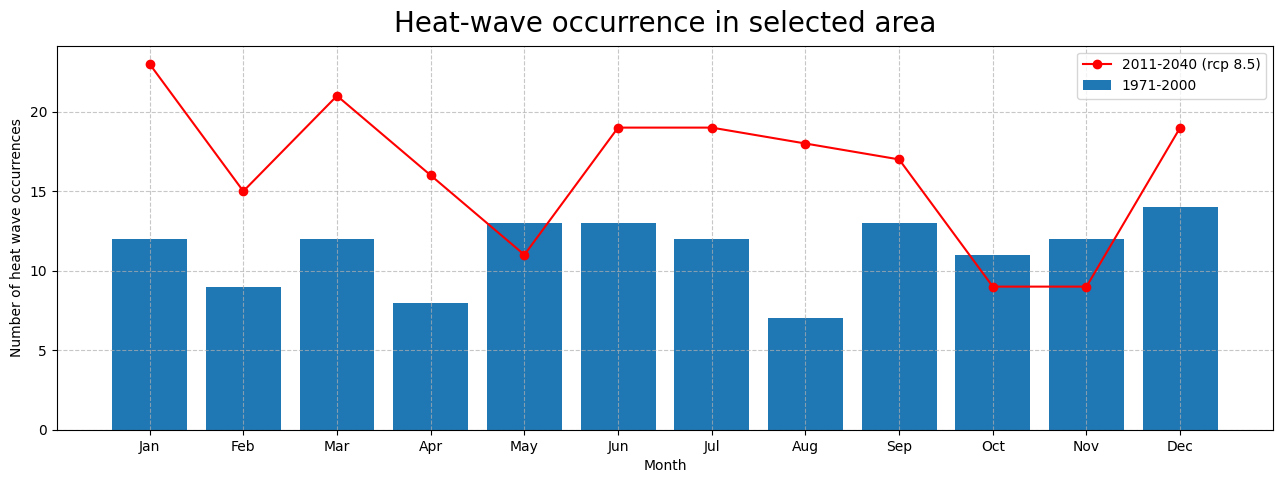

In [94]:
month = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
bar = pixel_values_hm
line = pixel_values_p1m
fig, ax = plt.subplots()
ax.bar(month, bar, label='1971-2000')
ax.plot(month, line, color='red', marker='o', label='2011-2040 (rcp 8.5)')
ax.set_xlabel('Month')
ax.set_ylabel('Number of heat wave occurrences')
ax.set_title('Heat-wave occurrence in selected area', fontsize=20, pad=10)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.7)
plt.subplots_adjust(left=0.1, bottom=0.1, right=2, top=0.9)
plt.show()

- This graph compare the heat-wave occurence for month for years 1971-2000 and 2011-2040

### Comparison by years

We compare the heat wave occurence in the observed period (1971-2000) and projection (2011-2040) for choosen rcp. We selected these period because these ale the most used climate period by CDS. 

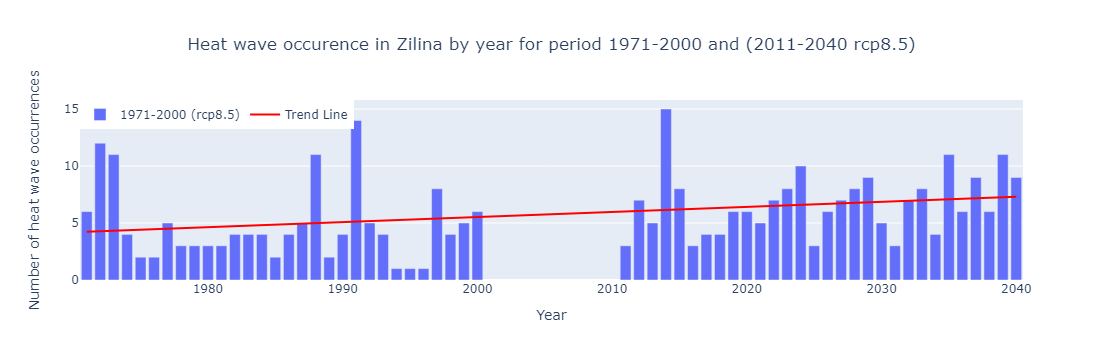

In [48]:
# merge past and future
b = pixel_values_hy + pixel_values_p1y
# This is x and y of the regression line
bar = b
yearh=list(range(1971, 2001))
yearp1=list(range(2011, 2041))
g=yearh+yearp1
year = g
#Creating a data frame out of series
df = pd.DataFrame({'year': year,'bar': bar})
x = df['year'].astype(int).values.reshape(-1, 1)
y = df['bar'].values
# Calling a function for linear regression
model = LinearRegression()
model.fit(x, y)
y_pred = model.predict(x)
fig = go.Figure()
#Adding a shape of graph
fig.add_trace(go.Bar(x=df['year'], y=df['bar'], name='1971-2000 (rcp8.5)'))
fig.add_trace(go.Scatter(x=df['year'], y=y_pred, mode='lines', name='Trend Line', line=dict(color='red')))
# Adding a description of graph
fig.update_layout(title='Heat wave occurence in Zilina by year for period 1971-2000 and (2011-2040 rcp8.5)', title_x = 0.5,
                  xaxis_title='Year',
                  yaxis_title='Number of heat wave occurrences',
                  showlegend=True,
                  legend=dict(x=0, y=1, traceorder='normal', orientation='h'),
                  barmode='stack')
fig.show()

## Conclusion

Monthly comaprison shows in which months we can expect the highest increase of the Heat-wave occurence. Yearly comparison show that the trend of the Heat-wave occurence should rising, however how steep the trendline will be depends on the rcp and are which we choose. 

# 3. XCLIM Heat wave computation

XCLIM is an operational Python library for climate services, providing numerous climate-related indicator tools with an extensible framework for constructing custom climate indicators, statistical downscaling and bias adjustment of climate model simulations, as well as climate model ensemble analysis tools.
XCLIMim is built using xarray and can seamlessly benefit from the parallelization handling provided by dask. Its objective is to make it as simple as possible for users to perform typical climate services data treatment workflows. Leveraging xarray and dask, users can easily bias-adjust climate simulations over large spatial domains or compute indices from large climate datase  [https://xclim.readthedocs.io/en/stable/readme.html]t

Examples of the code for the computing of the climate indices:
s.
- xclim.indices.heat_wave_max_length(tasmin, tasmax, thresh_tasmin='22.0 degC', thresh_tasmax='30 degC', window=3, freq='YS', op='>', resample_before_rl=True)
  
The thresholds of 22° and 25°C for night temperatures and 30° and 35°C for day temperatures were selected by Health Canada professionals, following a temperature–mortality analysis. These absolute temperature thresholds characterize the occurrence of hot weather events that can result in adverse health outcomes for Canadian communities [Casati et al., 2013].

In Robinson [2001], the parameters would be: thresh_tasmin=27.22, thresh_tasmax=39.44, window=2 (81F, 103F).
Casati, Yagouti, and Chaumont [2013], Robinson [2001]

- The biggest difference vs PESETA IV is that in XCLIM is the treshold for the heat waves calculated directly from the 30 years (rough estimate, identifies heat wave mainly in summer months), while in PESETA IV is calculated for monthly values from 30 years and we can detect also seasonal heat-wave changes. 

### XCLIM packages

In [14]:
import xclim.indices as xci
import xclim

### Data 
- For XCLIM we are using the same data as for PESETA IV + data about minimum air temperature
- These data are downloaded at the beginning of this notebook

In [15]:
# 1. Data are for 5 year periods, you can select one which you prefer or merge all in one... 
# Maximum temperature
dmax = xr.open_mfdataset(f'{data_dir}/tasmax*.nc', decode_coords='all')
rotated_pole = ccrs.RotatedPole(pole_latitude=39.25, pole_longitude=-162)
dmax.rio.write_crs(rotated_pole, inplace=True)
# Minimum temperature
dmin = xr.open_mfdataset(f'{data_dir}/tasmin*.nc', decode_coords='all')
rotated_pole = ccrs.RotatedPole(pole_latitude=39.25, pole_longitude=-162)
dmin.rio.write_crs(rotated_pole, inplace=True)

<xarray.Dataset> Size: 31GB
Dimensions:                     (time: 43830, bnds: 2, rlat: 412, rlon: 424,
                                 vertices: 4)
Coordinates:
  * time                        (time) datetime64[ns] 351kB 1971-01-01T12:00:...
    time_bnds                   (time, bnds) datetime64[ns] 701kB dask.array<chunksize=(1, 2), meta=np.ndarray>
  * rlat                        (rlat) float64 3kB -23.38 -23.26 ... 21.73 21.83
  * rlon                        (rlon) float64 3kB -28.38 -28.26 ... 18.05 18.16
    lat                         (rlat, rlon) float32 699kB dask.array<chunksize=(412, 424), meta=np.ndarray>
    lon                         (rlat, rlon) float32 699kB dask.array<chunksize=(412, 424), meta=np.ndarray>
    lat_vertices                (rlat, rlon, vertices) float32 3MB dask.array<chunksize=(412, 424, 4), meta=np.ndarray>
    lon_vertices                (rlat, rlon, vertices) float32 3MB dask.array<chunksize=(412, 424, 4), meta=np.ndarray>
    height                      float64 8B 2.0
    rotated_latitude_longitude  int32 4B 0
Dimensions without coordinates: bnds, vertices
Data variables:
    tasmin                      (time, rlat, rlon) float32 31GB dask.array<chunksize=(1, 412, 424), meta=np.ndarray>
Attributes: (12/30)
    institution:                    Climate Limited-area Modelling Community ...
    institute_id:                   CLMcom
    experiment_id:                  historical
    source:                         CLMcom-CCLM4-8-17
    model_id:                       CLMcom-CCLM4-8-17
    contact:                        cordex-cclm@dkrz.de
    ...                             ...
    table_id:                       Table day (Sept 2013) 0cf1782745489246c9f...
    modeling_realm:                 atmos
    realization:                    1
    cmor_version:                   2.9.1
    tracking_id:                    hdl:21.14103/35bbe6d5-f1fb-4311-bb17-8e16...
    c3s_disclaimer:                 This data has been produced in the contex...

- We can select our own bbox or use the selected one at the begginig of the notebook

In [16]:
dmax=dmax.rio.clip_box(minx=bbox[0], miny=bbox[1], maxx=bbox[2], maxy=bbox[3])  
dmin=dmin.rio.clip_box(minx=bbox[0], miny=bbox[1], maxx=bbox[2], maxy=bbox[3])  

In [17]:
# 2. Convert from K to °C
# Max Temperature
dmax=dmax['tasmax']
tasmax=dmax - 273.15
tasmax=tasmax.assign_attrs(dmax.attrs)
tasmax.attrs['units']='°C'
# Min Temperature
dmin=dmin['tasmin']
tasmin=dmin - 273.15
tasmin=tasmin.assign_attrs(dmin.attrs)
tasmin.attrs['units']='°C'
# 3. Select a time period for maximum temperature
# Max T
tasmaxh=tasmax.sel(time=slice("1971-01-01", "2000-12-31"))
tasmaxp1=tasmax.sel(time=slice("2011-01-01", "2040-12-31"))
tasmaxp2=tasmax.sel(time=slice("2041-01-01", "2070-12-31"))
tasmaxp3=tasmax.sel(time=slice("2071-01-01", "2100-12-31"))
tasmaxp=tasmax.sel(time=slice("2011-01-01", "2100-12-31"))
# Min T
tasminh=tasmin.sel(time=slice("1971-01-01", "2000-12-31"))
tasminp1=tasmin.sel(time=slice("2011-01-01", "2040-12-31"))
tasminp2=tasmin.sel(time=slice("2041-01-01", "2070-12-31"))
tasminp3=tasmin.sel(time=slice("2071-01-01", "2100-12-31"))
tasminp=tasmin.sel(time=slice("2011-01-01", "2100-12-31"))

### Calculation of the Heat waves 

##### Treshold temperatures based on the percentile:
1. compute the percentile for your selected area
2. calculate the mean value for your selected area

##### Treshold temperatures based on the impact on human health: 
1. based on the preferred studies e.g.: A multi-city epidemiologic study in Europe found that the mortality threshold for heat effects was 29.4 °C for Mediterranean cities and 23.3 °C for the north European cities [https://ehjournal.biomedcentral.com/articles/10.1186/s12940-022-00921-4].
2. or the tresholds given by your national meteorological or health service. 

In [18]:
# Heat-wave index
HWIp1=xclim.indices.heat_wave_index(tasmaxp, thresh='25.0 degC', window=5, freq='YS', op='>', resample_before_rl=True)
HWIh=xclim.indices.heat_wave_index(tasmaxh, thresh='25.0 degC', window=5, freq='YS', op='>', resample_before_rl=True)
# Heat-wave frequency
HWFp1=xclim.indices.heat_wave_frequency(tasminp, tasmaxp, thresh_tasmin='17.0 degC', thresh_tasmax='28.0 degC', window=3, freq='YS', op='>', resample_before_rl=True)
HWFh=xclim.indices.heat_wave_frequency(tasminh, tasmaxh, thresh_tasmin='17.0 degC', thresh_tasmax='28.0 degC', window=3, freq='YS', op='>', resample_before_rl=True)
# Heat-wave total length
HWTLp1=xclim.indices.heat_wave_total_length(tasminp, tasmaxp, thresh_tasmin='17.0 degC', thresh_tasmax='28.0 degC', window=3, freq='YS', op='>', resample_before_rl=True)
HWTLh=xclim.indices.heat_wave_total_length(tasminh, tasmaxh, thresh_tasmin='17.0 degC', thresh_tasmax='28.0 degC', window=3, freq='YS', op='>', resample_before_rl=True)

In [22]:
# Set a right type
HWFp1=HWFp1.astype(np.float64)

In [23]:
## CRS for Eurocordex data
rotated_pole = ccrs.RotatedPole(pole_latitude=39.25, pole_longitude=-162)
HWIp1.rio.write_crs(rotated_pole, inplace=True)
HWFp1.rio.write_crs(rotated_pole, inplace=True)
HWTLp1.rio.write_crs(rotated_pole, inplace=True)

<xarray.DataArray (time: 90, rlat: 17, rlon: 20)> Size: 245kB
dask.array<mul, shape=(90, 17, 20), dtype=float64, chunksize=(1, 17, 20), chunktype=numpy.ndarray>
Coordinates:
  * rlat                        (rlat) float64 136B -2.805 -2.695 ... -1.045
  * rlon                        (rlon) float64 160B -0.435 -0.325 ... 1.655
    lat                         (rlat, rlon) float32 1kB 47.94 47.94 ... 49.68
    lon                         (rlat, rlon) float32 1kB 17.35 17.52 ... 20.56
    height                      float64 8B 2.0
    rotated_latitude_longitude  int32 4B 0
  * time                        (time) datetime64[ns] 720B 2011-01-01 ... 210...
    spatial_ref                 int32 4B 0
Attributes:
    units:    d

- This step will takes a few minutes

In [24]:
HWIp1.rio.to_raster(raster_path=f'{data_dir}/HWIp1.tif')
HWFp1.rio.to_raster(raster_path=f'{data_dir}/HWFp1.tif')
HWTLp1.rio.to_raster(raster_path=f'{data_dir}/HWTLp1.tif')

### Select the point on the map for plotting 

In [26]:
#import xarray as xr
import rioxarray
# Open the raster dataset
HWIp=f'{data_dir}/HWIp1.tif'
HWIp= xr.open_dataset(HWIp)
#
HWFp = f'{data_dir}/HWFp1.tif'
HWFp = xr.open_dataset(HWFp)
#
HWTLp=f'{data_dir}/HWTLp1.tif'
HWTLp= xr.open_dataset(HWTLp)
#
# Select the band_data variable if needed
HWIp = HWIp['band_data']
HWFp = HWFp['band_data']
HWTLp = HWTLp['band_data']
#HWbarp1y = HWbarp1y['band_data']
# Define the target CRS
target_crs = 'EPSG:4326'  # WGS84
# Write the CRS information to the dataset
HWIp.rio.write_crs(rotated_pole, inplace=True)
HWFp.rio.write_crs(rotated_pole, inplace=True)
HWTLp.rio.write_crs(rotated_pole, inplace=True)
# Reproject the clipped raster dataset to the target CRS
HWIp_reprojected = HWIp.rio.reproject(target_crs)
HWFp_reprojected = HWFp.rio.reproject(target_crs)
HWTLp_reprojected = HWTLp.rio.reproject(target_crs)
# Optionally, you can save the reprojected raster to a new file
#output_path = f'{data_dir}/'
HWIp_reprojected.rio.to_raster(raster_path=f'{data_dir}/HWIp_reprojected.tif')
HWIpm=HWIp_reprojected.mean(dim='band', skipna=True,  keep_attrs=True)
HWIpm.rio.to_raster(raster_path=f'{data_dir}/HWIp1m.tif')
#
HWFp_reprojected.rio.to_raster(raster_path=f'{data_dir}/HWFp_reprojected.tif')
HWFpm=HWFp_reprojected.mean(dim='band', skipna=True,  keep_attrs=True)
HWFpm.rio.to_raster(raster_path=f'{data_dir}/HWFp1m.tif')
#
HWTLp_reprojected.rio.to_raster(raster_path=f'{data_dir}/HWTLp_reprojected.tif')
HWTLpm=HWTLp_reprojected.mean(dim='band', skipna=True,  keep_attrs=True) 
HWTLpm.rio.to_raster(raster_path=f'{data_dir}/HWTLp1m.tif')

In [114]:
HWFpm.rio.to_raster(raster_path=f'{data_dir}/HWFpm.tif')

In [27]:
import cartopy.crs as ccrs # netcdf data projection
import xarray as xr
import rioxarray
import rasterio as rio
from ipyleaflet import Map, DrawControl, Marker, LayersControl
import ipywidgets as widgets
import leafmap.leafmap as leafmap
from localtileserver import get_leaflet_tile_layer, TileClient

In [30]:
# First, create a tile server from local raster file
client1 = TileClient(f'{data_dir}/HWIp1m.tif')
client2 = TileClient(f'{data_dir}/HWFp1m.tif')
client3 = TileClient(f'{data_dir}/HWTLp1m.tif')

# Create ipyleaflet tile layer from that server
t1 = get_leaflet_tile_layer(client1, cmap='Reds', opacity=0.5, nodata=0,name='Heat-wave index')
t2 = get_leaflet_tile_layer(client2, cmap='Reds', opacity=0.5, nodata=0,name='Heat-wave frequency')
t3 = get_leaflet_tile_layer(client3, cmap='Reds', opacity=0.5, nodata=0,name='Heat-wave total length')

m = Map(center=client1.center(), zoom=client1.default_zoom)
m = Map(center=client2.center(), zoom=client2.default_zoom)
m = Map(center=client3.center(), zoom=client3.default_zoom)
m.add(t1)
m.add(t2)
m.add(t3)

control = LayersControl(position='topright')
m.add_control(control)

# Create lists to store point coordinates
point_lon_list = []
point_lat_list = []

# Create a DrawControl with point drawing enabled
draw_control = DrawControl(marker={'shapeOptions': {'color': '#FF0000'}})
# Add the DrawControl to the map
m.add_control(draw_control)

# Create a text widget to display coordinates
coord_output = widgets.Text(placeholder='Coordinates will appear here', disabled=True)

# Define a function to handle draw events
def handle_draw(self, action, geo_json):
    if action == 'created':
        if geo_json['geometry']['type'] == 'Point':
            # Extract coordinates of the point
            lon, lat = geo_json['geometry']['coordinates']
            # Update text widget with coordinates
            coord_output.value = f'Coordinates: ({lon:.2f}, {lat:.2f})'
            # Append coordinates to lists
            point_lon_list.append(lon)
            point_lat_list.append(lat)
            # Create and add a marker to the map
            marker = Marker(location=(lat, lon))
            m.add_layer(marker)

# Attach the event handler to the DrawControl
draw_control.on_draw(handle_draw)

# Arrange the map and text widget vertically
display(widgets.VBox([m, coord_output]))

- On the picture above, we can find the ploted raster data in the area which we select by bbox at the begginig of the code
- These rasters are provides for three type of data, which you can select in the right upper corner
- These data are scaled for Heat-wave Index, Heat-wave frequency and Heat-wave total lenght (total duration) for the projected period 2011-2100
- This graphical comaparison is only for the better imagination which area in your selected area will more suffer by heat (dark red will be most affected)
- For the visual comparison of the number of the heat occurence you need to select a point (flag) from the left panel and select a pixel which you prefer 

In [33]:
import rasterio
def latlon_to_pixel(raster_file_hwi, lat, lon):
    with rasterio.open(raster_file_hwi) as src:
        # Transform lat/lon coordinates to pixel coordinates
        row, col = src.index(lon, lat)
        # Return row and column indices
        return row, col
def get_pixel_values(raster_file_hwi, lat, lon):
    with rasterio.open(raster_file_hwi) as src:
        # Get the row and column indices for the given lat/lon
        row, col = latlon_to_pixel(raster_file_hwi, lat, lon)
        # Read pixel values from each band
        pixel_values_hwi = [band[row, col] for band in src.read()]
        # Return pixel values for each band
        return pixel_values_hwi
#
def latlon_to_pixel(raster_file_hwf, lat, lon):
    with rasterio.open(raster_file_hwf) as src:
        # Transform lat/lon coordinates to pixel coordinates
        row, col = src.index(lon, lat)
        # Return row and column indices
        return row, col
def get_pixel_values(raster_file_hwf, lat, lon):
    with rasterio.open(raster_file_hwf) as src:
        # Get the row and column indices for the given lat/lon
        row, col = latlon_to_pixel(raster_file_hwf, lat, lon)
        # Read pixel values from each band
        pixel_values_hwf = [band[row, col] for band in src.read()]
        # Return pixel values for each band
        return pixel_values_hwf
#
def latlon_to_pixel(raster_file_hwtl, lat, lon):
    with rasterio.open(raster_file_hwtl) as src:
        # Transform lat/lon coordinates to pixel coordinates
        row, col = src.index(lon, lat)
        # Return row and column indices
        return row, col
def get_pixel_values(raster_file_hwtl, lat, lon):
    with rasterio.open(raster_file_hwtl) as src:
        # Get the row and column indices for the given lat/lon
        row, col = latlon_to_pixel(raster_file_hwtl, lat, lon)
        # Read pixel values from each band
        pixel_values_hwtl = [band[row, col] for band in src.read()]
        # Return pixel values for each band
        return pixel_values_hwtl
# Example usage
raster_file_hwi = f'{data_dir}/HWIp_reprojected.tif'
raster_file_hwf = f'{data_dir}/HWFp_reprojected.tif'
raster_file_hwtl = f'{data_dir}/HWTLp_reprojected.tif'
# 49.219429, 18.737165
lat = 49.219429  # Example latitude
lon = 18.737165 # Example longitude
#
#pixel_values = get_pixel_values(raster_file, lat, long)
pixel_values_hwi = get_pixel_values(raster_file_hwi, lat, lon)
pixel_values_hwf = get_pixel_values(raster_file_hwf, lat, lon)
pixel_values_hwtl = get_pixel_values(raster_file_hwtl, lat, lon)
#print("Pixel values:", pixel_values)

### Heat wave index
Number of days that are part of a heatwave, defined as five or more consecutive days over a threshold of 25 degrees.

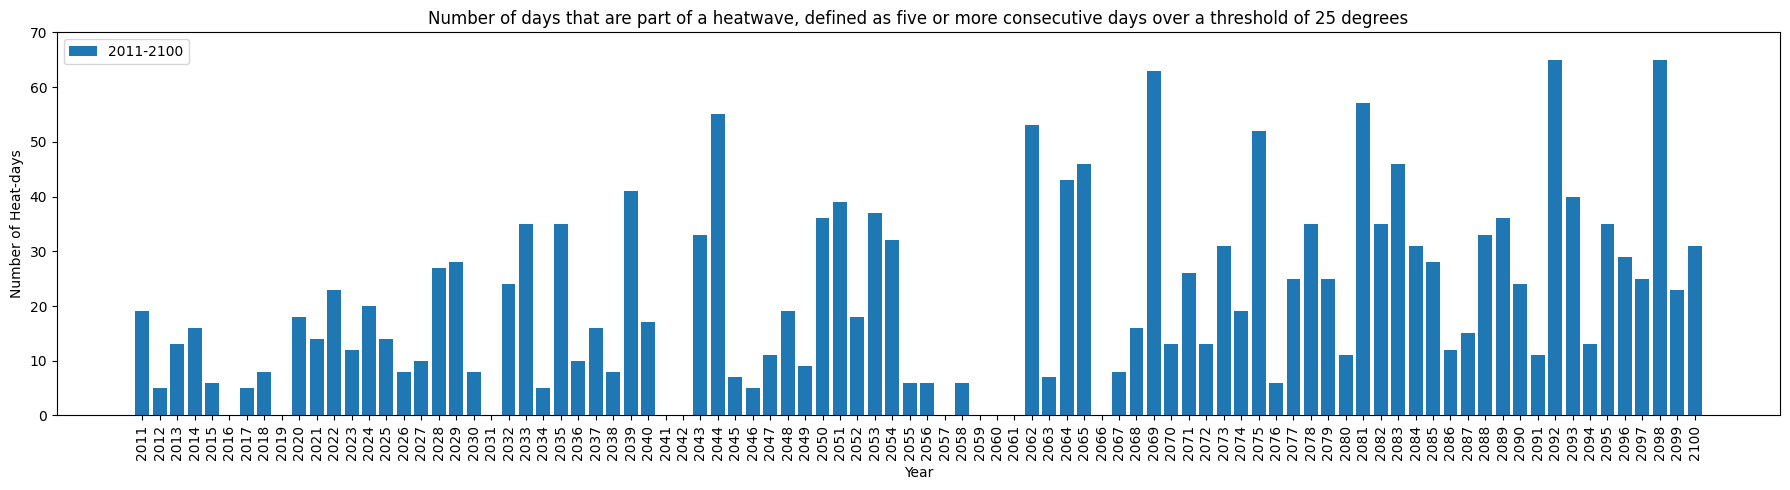

In [46]:
# Plot the data
fig, ax = plt.subplots(figsize=(18, 5))
# Example data for illustration purposes
years = list(range(2011, 2101))
plt.title('Number of days that are part of a heatwave, defined as five or more consecutive days over a threshold of 25 degrees') 
ax.bar(years, pixel_values_hwi, label='2011-2100')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Heat-days')
# Set x-axis ticks and labels
ax.set_xticks(years[::1])  # Set x-axis ticks every 10 years
ax.set_xticklabels(years[::1], rotation=90)  # Set x-axis tick labels to every 10 years and rotate them for better readability
ax.set_ylim(0, 70)  # Adjust y-axis limit as needed
plt.legend()
plt.tight_layout()
plt.show()

### Heat-wave frequency
- Number of heat waves over a given period. A heat wave is defined as an event where the minimum and maximum daily temperature both exceed specific thresholds over a minimum number of days.
- The number of the heat-waves depends strictly on the treshold which we select


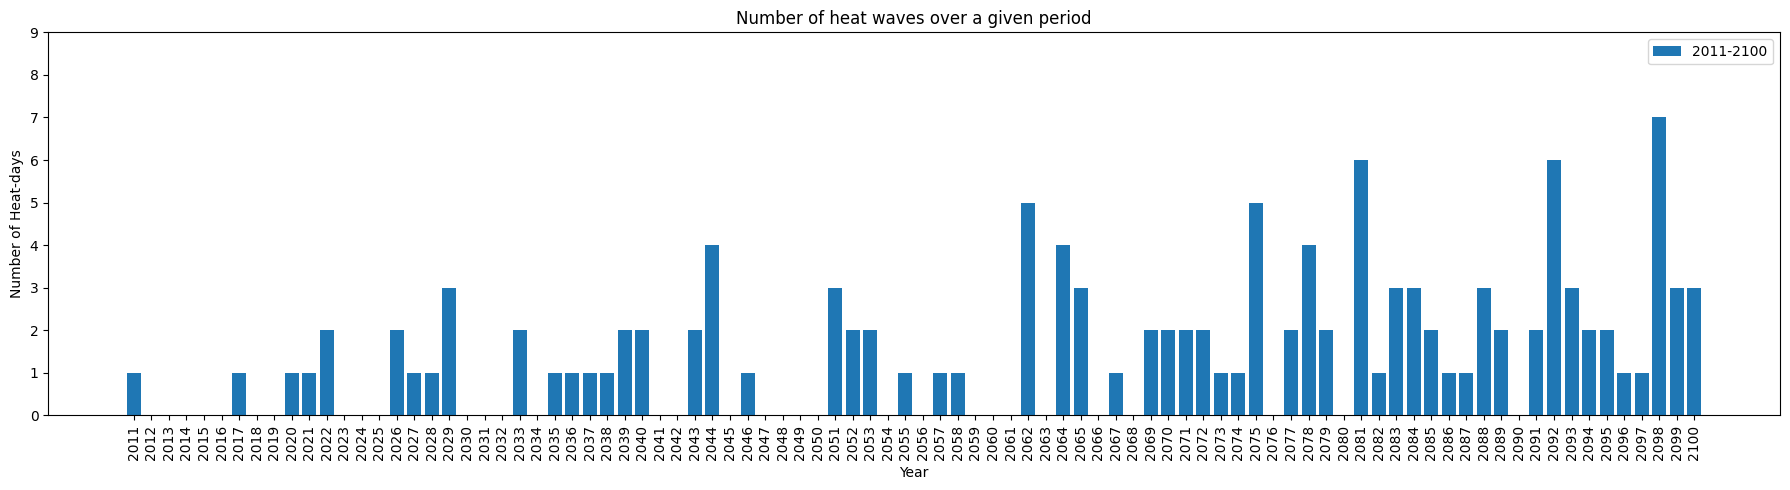

In [50]:
# Plot the data
fig, ax = plt.subplots(figsize=(18, 5))
# Example data for illustration purposes
years = list(range(2011, 2101))
plt.title('Number of heat waves over a given period') 
ax.bar(years, pixel_values_hwf, label='2011-2100')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Heat-days')
# Set x-axis ticks and labels
ax.set_xticks(years[::1])  # Set x-axis ticks every 10 years
ax.set_xticklabels(years[::1], rotation=90)  # Set x-axis tick labels to every 10 years and rotate them for better readability
ax.set_ylim(0, 9)  # Adjust y-axis limit as needed
plt.legend()
plt.tight_layout()
plt.show()

### Heat wave total length
Total length of heat waves over a given period. A heat wave is defined as an event where the minimum and maximum daily temperature both exceeds specific thresholds over a minimum number of days. This the sum of all days in such events.

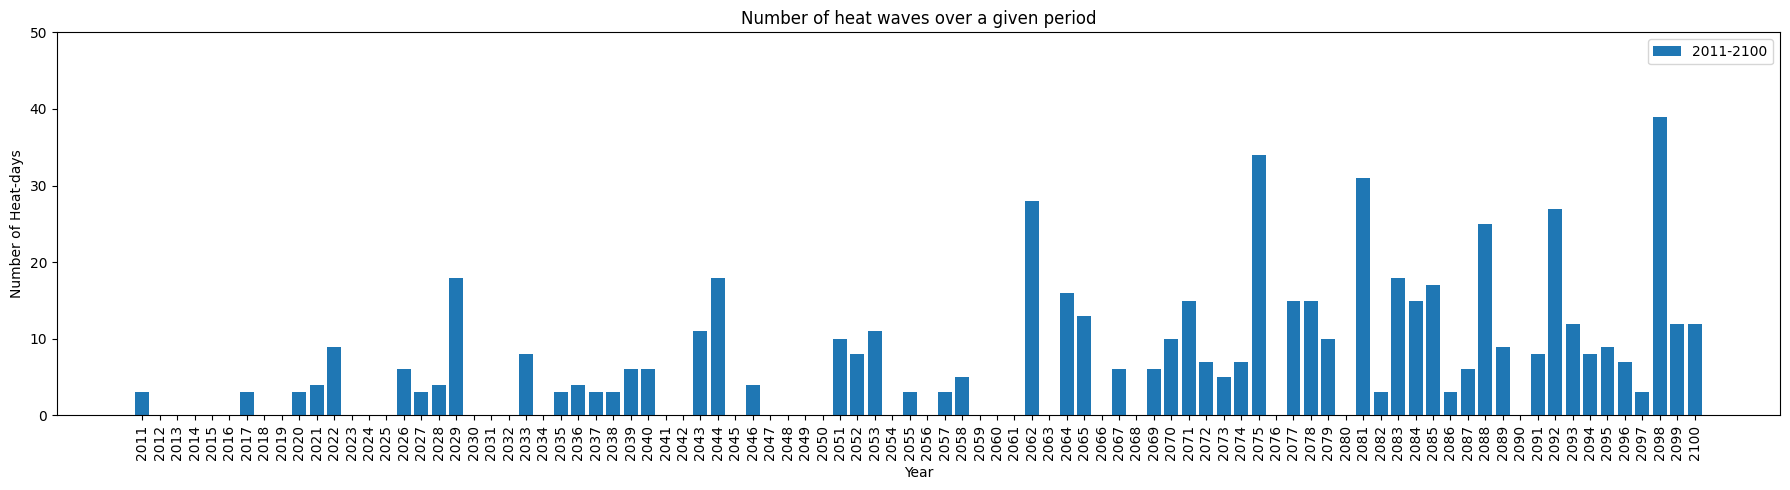

In [54]:
# Plot the data
fig, ax = plt.subplots(figsize=(18, 5))
# Example data for illustration purposes
years = list(range(2011, 2101))
plt.title('Number of heat waves over a given period') 
ax.bar(years, pixel_values_hwtl, label='2011-2100')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Heat-days')
# Set x-axis ticks and labels
ax.set_xticks(years[::1])  # Set x-axis ticks every 10 years
ax.set_xticklabels(years[::1], rotation=90)  # Set x-axis tick labels to every 10 years and rotate them for better readability
ax.set_ylim(0, 50)  # Adjust y-axis limit as needed
plt.legend()
plt.tight_layout()
plt.show()